In [14]:
import time
import scipy
import numpy as np
from numpy import array
from scipy.special import roots_legendre
from scipy import sparse
import matplotlib.pyplot as plt

# Formulação forte
Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha$ e $\beta$, determine $u:[0,1]\rightarrow\mathbb{R}$ tal que
\begin{align}
\left\{
\begin{aligned}
&-\alpha u_{xx}(x) + \beta u(x) = f(x),\quad x\in]0,1[,
\\
&u(0)=u(1)=0.
\end{aligned}\right.
\end{align}

Exemplos de solução exata para o problema acima:
*   Ex. 1. Se $\alpha=1$, $\beta=0$ e $f(x)=8$, então $u(x)=-4x(x-1)$.
*   Ex. 2. Se $\alpha=\beta=1$ e $f(x)=x$, então $u(x)=x+\frac{e^{-x}-e^x}{e-e^{-1}}$.
*   Ex. 3. Se $\alpha=\beta=1$ e $f(x)=-2\pi^2\cos(2\pi x) +\sin^2(\pi x)$, então $u(x)=\sin^2(\pi x)$.


In [15]:
def dados_de_entrada(exemplo):
  # Cenário 1
  if exemplo == 1:
    alpha = 1; beta  = 0
    def f(x):
      return 8*x**0
    def u(x):
      return -4*x*(x-1)

  # Cenário 2
  elif exemplo == 2:
    alpha = 1; beta  = 1
    def f(x):
      return x
    def u(x):
      return x + (np.exp(-x)-np.exp(x))/(np.exp(1)-np.exp(-1))

  # Cenário 3
  elif exemplo == 3:
    alpha = 1; beta  = 1
    def f(x):
      return -(2*np.pi**2) * np.cos(2*np.pi*x) + np.sin(np.pi*x)**2
    def u(x):
      return np.sin(np.pi*x)**2

  # exemplo escolhido
  return alpha, beta, f, u

# Problema aproximado - via método de Galerkin
Dados $f:[0,1]\rightarrow\mathbb{R}$ e constantes reais $\alpha$ e $\beta$, determine $u_h\in V_m=[\varphi_0,\varphi_1,\dots,\varphi_{m-1}]$ tal que
\begin{align}
  \alpha \int_0^1\frac{du_h}{dx}(x)\frac{dv_h}{dx}(x)dx
+ \beta  \int_0^1 u_h(x)v_h(x)dx
= \int_0^1f(x)v_h(x)dx,
\quad \forall v_h\in V_m.
\end{align}

## Formulação matricial
Tomando $\displaystyle u_h(x) = \sum_{j=0}^{m-1} c_j\varphi_j(x)$ e $v_h=\varphi_i$, para $i=0,1,\dots,m-1$, temos a forma matriz-vetor do problema aproximado. Ou seja, o problema recai em determinar um vetor $c\in\mathbb{R}^m$ tal que
\begin{align*}
Kc=F,
\end{align*}
em que, para $i,j\in{0,1,\dots,m-1}$, as entradas da matriz $K$ e do vetor $F$ são definidas como segue:
\begin{align*}
K_{i,j} =
  \alpha \int_0^1\frac{d\varphi_i}{dx}(x)\frac{d\varphi_j}{dx}(x)dx
+ \beta  \int_0^1 \varphi_i(x)\varphi_j(x)dx
\quad\text{e}\quad
F_i =
\int_0^1f(x)\varphi_i(x)dx.
\end{align*}

# Base linear por partes
Dado $n_e\in\mathbb{N}$, seja $0=x_0< x_1< \dots < x_{n_{e-1}} < x_{n_e}=1$ uma partição uniforme de $[0,1]$, com o diâmetro de cada elemento dado por $h=1/n_{e}$.
No caso da base linear por partes para o espaço aproximado $V_m$, as funções serão escolhidas a partir das exibidas a seguir.

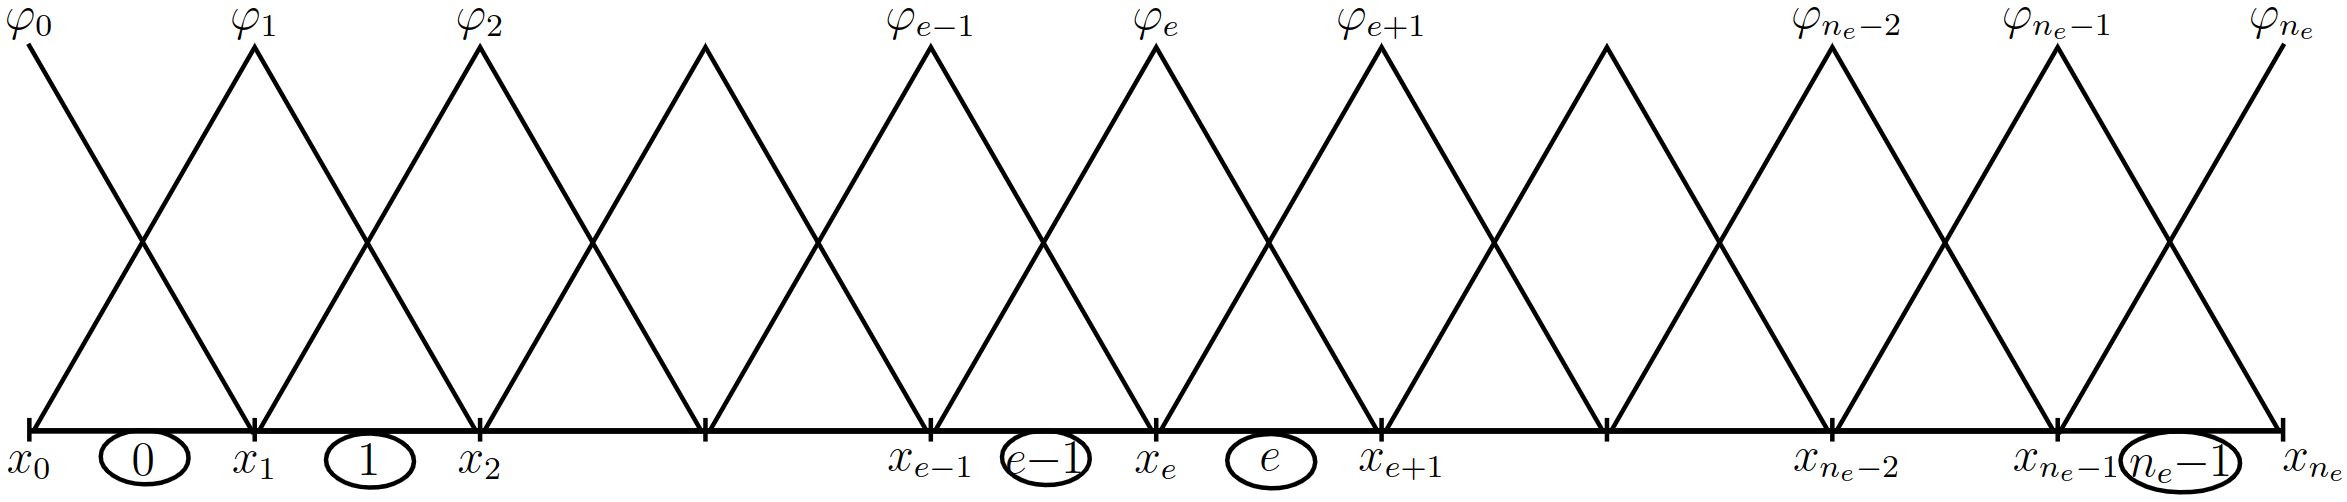

A relação entre a nomenclatura local e global das funções da base linear por partes é a seguinte:

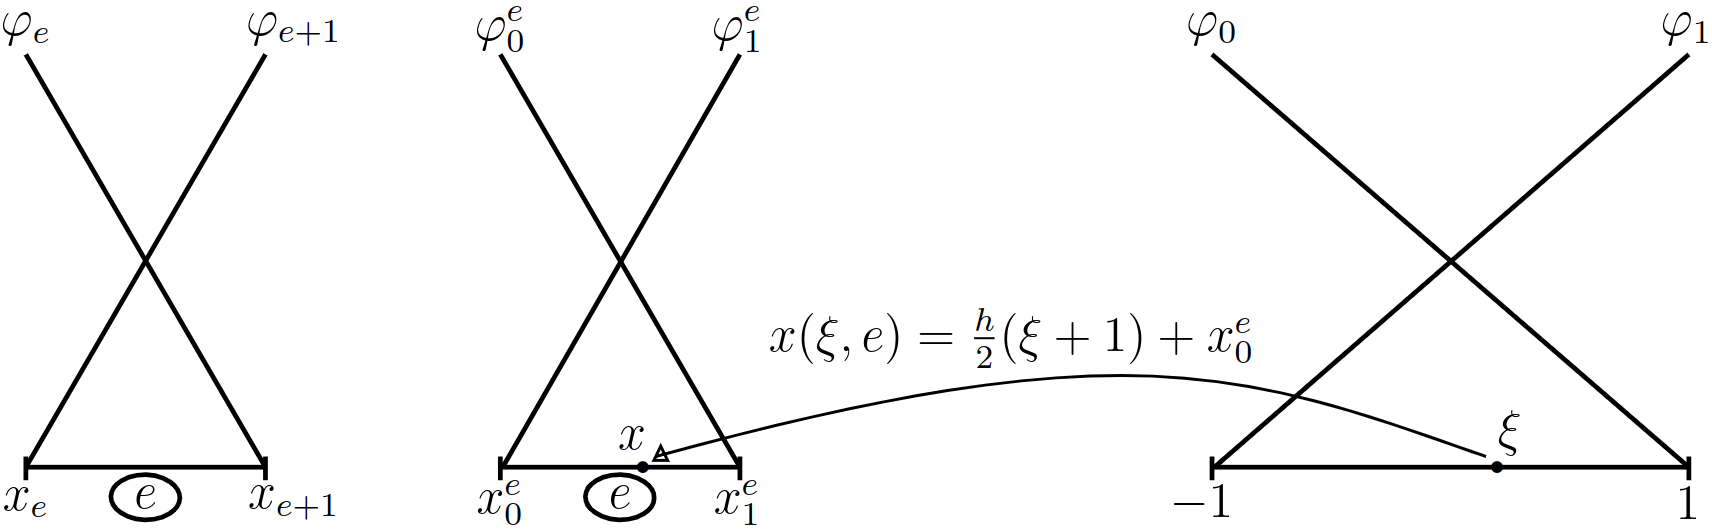

In [16]:
# Função phi(P): Calcula as funções phi_0(P) e phi_1(P)
def phi(P):
  return array([
    (1 - P) / 2,  # phi_0(P)
    (1 + P) / 2 ])# phi_1(P)

# Função dphi(P): Calcula as derivadas das funções phi_0(P) e phi_1(P)
def dphi(P):
  return array([
    -1/2*P**0,   # dphi_0(P)
     1/2*P**0 ]) # dphi_1(P)

# Função monta_LG: Retorna a relação entre a numeração local e global das funções phi
def monta_LG(ne):
  return array([
     np.arange(0,ne),
     np.arange(1,ne+1)])

# Função monta_EQ: Retorna um vetor com a nova numeração das funções globais phi
def monta_EQ(ne):
  m = ne-1
  EQ = array([m, *np.arange(0,m), m])
  return EQ, m

# Função monta_EQoLG
def monta_EQoLG(ne):
  LG = monta_LG(ne)
  EQ, m = monta_EQ(ne)
  EQoLG = EQ[LG]
  return EQoLG, m

# Função monta_xPTne: Retorna um array 2D (npg,ne) com as coordenadas globais dos pontos de Gauss em todos os elementos
def monta_xPTne(h,P):
  return (h/2)*(P+1)[:,np.newaxis] + np.arange(0, 1, h)

# Monta K
A matriz local $K^e$ é definida como:
\begin{align*}\displaystyle
K_{a,b}^e =
  \frac{2\alpha}{h} \int_{-1}^{1}\frac{d\varphi_a}{d\xi}(\xi)\frac{d\varphi_b}{d\xi}(\xi)d\xi
+ \frac{\beta h}{2}  \int_{-1}^{1} \varphi_a(\xi)\varphi_b(\xi)d\xi,
\quad\text{com}\quad
a,\,b\in\{0,1\}.
\end{align*}
Resolvendo as integrais utilizando quadratura Gaussiana e reescrevendo o resultado de forma vetorizada, temos
\begin{align*}
K^e
=&
\frac{2\alpha}{h}
\left[
\begin{aligned}
& W.*\frac{d\varphi_0}{d\xi}(P)  \\
& W.*\frac{d\varphi_1}{d\xi}(P)
\end{aligned}
\right]_{2\times n_{pg}}*
\Big[\frac{d\varphi_0}{d\xi}(P)^T \; \frac{d\varphi_1}{d\xi}(P)^T\Big]_{n_{pg}\times 2}
+ \frac{\beta h}{2}
\left[
\begin{aligned}
& W.*\varphi_0(P)\\
& W.*\varphi_1(P)
\end{aligned}
\right]_{2\times n_{pg}}*
\Big[\varphi_0(P)^T\;\varphi_1(P)^T\Big]_{n_{pg}\times 2}
\\[10pt]
=&
\frac{2\alpha}{h}\Big[W.*dphiP\Big]_{2\times n_{pg}}*\Big[dphiPT\Big]_{n_{pg}\times 2}
+ \frac{\beta h}{2}  \Big[W.*phiP\Big]_{2\times n_{pg}}*\Big[phiPT\Big]_{n_{pg}\times 2}.
\end{align*}

Uma vez construida a matriz local $K^e$, a montagem vetorizada da matriz $K$ é a seguinte:

In [17]:
def monta_K(alpha,beta,EQoLG,m):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 2; P, W = roots_legendre(npg)

  phiP = phi(P); dphiP = dphi(P)
  Ke = (2*alpha/h)*(W*dphiP)@dphiP.T + (beta*h/2)*(W*phiP)@phiP.T
  #display("Ke",Ke)

  S = Ke.reshape(-1).repeat(ne)
  I = EQoLG[[0,1,0,1],:].reshape(-1)
  J = EQoLG[[0,0,1,1],:].reshape(-1)

  K = sparse.coo_matrix((S,(I,J)),shape=(m+1,m+1)).tocsr()[:-1, :-1]
  return K

# Monta F
O vetor local $F^e$ é definido como:
\begin{align*}
F_a^e =
\frac{h}{2}\int_{-1}^1f\big(x(\xi,e)\big)\varphi_a(\xi)d\xi,
\quad\text{com}\quad
a\in\{0,1\}.
\end{align*}

Resolvendo a integral utilizando quadratura Gaussiana e reescrevendo o resultado de forma vetorizada, temos
\begin{align*}
F^e
=& \frac{h}{2}
\left[
\begin{aligned}
& W.*\varphi_0(P) \\
& W.*\varphi_1(P)
\end{aligned}
\right]_{2\times n_{pg}}
* \Big[f\big(x(P^T,e)\big)\Big]_{n_{pg}\times 1}\\
=& \frac{h}{2}\Big[W.*phiP\Big]_{2\times n_{pg}} * \Big[f\big(x(P^T,e)\big)\Big]_{n_{pg}\times 1}.
\end{align*}

Uma vez construido o vetor local $F^e$, a montagem vetorizada de $F$ é a seguinte:

In [18]:
def monta_F(EQoLG,m):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 5; P, W = roots_legendre(npg)

  xPTne  = monta_xPTne(h,P)
  fxPTne = f(xPTne)
  locais = ((h/2)*W*phi(P))@fxPTne

  return np.bincount(EQoLG.reshape(-1), weights=locais.reshape(-1), minlength=m+1)[:-1]

# Calcula o erro
Para calcular o erro na norma do espaço $L^2(]0,1[)$, definido por
\begin{align*}
    \mathcal{E}_h=\|u-u_h\|=\sqrt{\int_0^1|u(x)-u_h(x)|^2dx },
\end{align*}
precisamos realizar o seguinte cálculo:
\begin{align*}
\mathcal{E}_h=\sqrt{
\frac{h}{2}\Big[\hspace{-1mm}\int_{-1}^{1}\hspace{-2mm} | u(x(\xi,0)) - c_0\varphi_1(\xi) |^2 d\xi
+\hspace{-1mm} \sum_{e=1}^{n_e-2}\hspace{-1mm} \int_{-1}^{1}\hspace{-2mm} | u(x(\xi,e)) - c_{e-1}\varphi_0(\xi) - c_{e}\varphi_1(\xi) |^2 d\xi
+\hspace{-1mm} \int_{-1}^{1}\hspace{-2mm} | u(x(\xi,n_e-1)) - c_{n_e-2}\varphi_0(\xi) |^2 d\xi\Big]
  }
\end{align*}

Resolvendo as integrais utilizando quadratura Gaussiana e reescrevendo o resultado de forma vetorizada, temos
\begin{align*}
&\mathcal{E}_h^2
=\frac{h}{2}
sum\Bigg(
\Big[W\Big]_{1\times n_{pg}}\hspace{-4mm}*
\Bigg[\Big|\Big[u\big(xPTne\big)\Big]_{n_{pg}\times n_e}\hspace{-4mm}-\Big[phiPT\Big]_{n_{pg}\times 2}\hspace{-4mm}*
\left[\begin{array}{cccccccccc}
0  &c_0&\dots&c_{n_e-3}&c_{n_e-2}\\
c_0&c_1&\dots&c_{n_e-2}&0
\end{array}\right]_{2\times n_e}
\Big|.\wedge 2\Bigg]_{n_{pg}\times n_e}
\Bigg).
\end{align*}

Nesta última expressão, resta observar que, definindo
$d=\left[\begin{array}{c}
c\\
0
\end{array}\right]_{(m+1)\times 1}$,
podemos reescrever o resultado como:
\begin{align*}
&\mathcal{E}_h^2
=\frac{h}{2}
sum\Bigg(
\Big[W\Big]_{1\times n_{pg}}*
\Bigg[\Big|\Big[u\big(xPTne\big)\Big]_{n_{pg}\times n_e}-\Big[phiPT\Big]_{n_{pg}\times 2}*
\big[d(EQoLG)\big]_{2\times n_e}
\Big|.\wedge 2\Bigg]_{n_{pg}\times n_e}
\Bigg).
\end{align*}


In [19]:
def erro_L2(u,c,EQoLG):
  ne = EQoLG.shape[1]; h = 1/ne

  npg = 5; P, W = roots_legendre(npg)

  phiPT = phi(P).T

  xPTne  = monta_xPTne(h,P)
  uxPTne = u(xPTne)

  d = array([*c,0])
  dEQoLG = d[EQoLG]

  return np.sqrt( (h/2)*np.sum( W @ (uxPTne - phiPT@dEQoLG)**2 ) )

# Obtendo a solução aproximada


'K'

array([[ 8.16666667, -3.95833333,  0.        ],
       [-3.95833333,  8.16666667, -3.95833333],
       [ 0.        , -3.95833333,  8.16666667]])

'F'

array([0.0625, 0.125 , 0.1875])

'c'

array([0.0352125 , 0.05685947, 0.05051862])

'erro L2:'

0.0029299183664998206

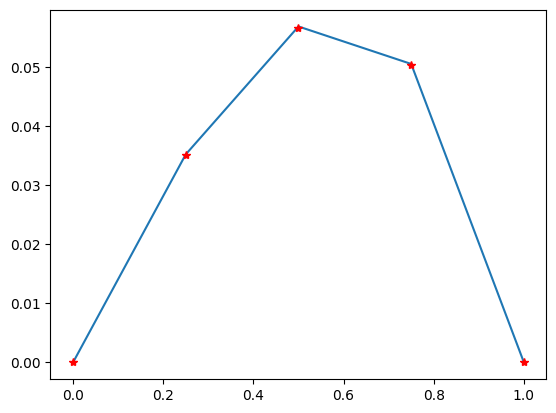

In [20]:
# Defina os dados de entrada
exemplo = 2
ne = 4
alpha, beta, f, u = dados_de_entrada(exemplo)

# Monta K e F
EQoLG,m = monta_EQoLG(ne)
K = monta_K(alpha,beta,EQoLG,m)
F = monta_F(EQoLG,m)

display("K",K.toarray())
display("F",F)

# Resolva o sistema linear Kc=F
c = scipy.sparse.linalg.spsolve(K,F)
display("c",c)

# Plot solução aproximada e exata
x = np.arange(0,1+1/ne,1/ne)
plt.plot(x,array([0,*c,0]))
plt.plot(x,u(x),'*r')

# Calcula o erro entre a solução aproximada e exata
erroL2 = erro_L2(u,c,EQoLG)
display('erro L2:', erroL2)

# Estudo de convergência do erro

'elapsed time'

14.440093994140625

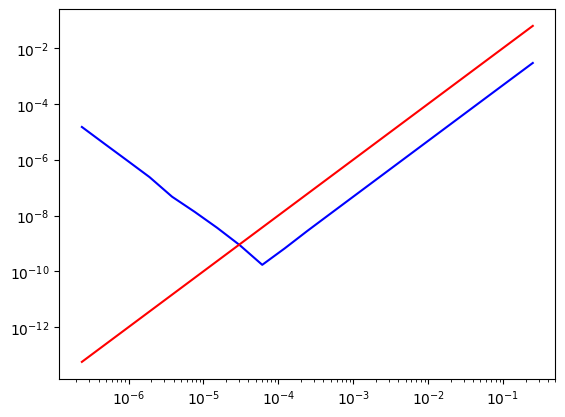

In [21]:
# Defina os dados de entrada
exemplo = 2
alpha, beta, f, u = dados_de_entrada(exemplo)
vec_ne = 2**np.arange(2,23)

# Inicialize os vetores para armazenar os valores de h e os erros
vec_h  = 1/vec_ne
vec_erro = np.zeros(len(vec_h))

# Itere através de vec_ne
t = time.time()
for i in range(len(vec_ne)):
  ne = vec_ne[i]

  # Monta a matriz de rigidez K e o vetor de carga F
  EQoLG,m = monta_EQoLG(ne)
  K = monta_K(alpha,beta,EQoLG,m)
  F = monta_F(EQoLG,m)

  # Resolva o sistema linear Kc=F
  c = scipy.sparse.linalg.spsolve(K,F)

  # Calcule o erro L2 entre a solução aproximada e a solução exata
  vec_erro[i] = erro_L2(u,c,EQoLG)
elapsed = time.time() - t
display("elapsed time",elapsed)

# Exiba o gráfico do em erro em escala log
plt.loglog(vec_h,vec_erro,'b')
plt.loglog(vec_h,vec_h**2,'r')